# Machine Predictions
In this notebook we analyse the predictions made by the **uncalibrated** surrogate model with the machine data and evaluate the errors. 

In [16]:
# set it up to autoreload updates
%load_ext autoreload
%autoreload 2

import json
import torch
import pandas as pd
from utils import load_lcls, plot_series, chunk_dataset
import matplotlib.pyplot as plt
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [56]:
full_data = pd.read_pickle('data/full_2022-09-23_12_18_58-07_00__2022-09-23_23_03_01-07_00.pkl')
full_data['beam_size'] = np.sqrt(full_data['OTRS:IN20:621:XRMS'] * full_data['OTRS:IN20:621:YRMS'])
full_data.head()

c:\Users\yvd17636\AppData\Local\miniconda3\envs\lume-epics-dev\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,timestamp,SOLN:IN20:121:BACT,QUAD:IN20:121:BACT,QUAD:IN20:122:BACT,QUAD:IN20:361:BACT,QUAD:IN20:371:BACT,QUAD:IN20:425:BACT,QUAD:IN20:441:BACT,QUAD:IN20:511:BACT,...,BPMS:IN20:731:X,OTRS:IN20:621:IMAGE,OTRS:IN20:621:XRMS,OTRS:IN20:621:YRMS,OTRS:IN20:621:ROI_XNP,OTRS:IN20:621:ROI_YNP,OTRS:IN20:621:X,OTRS:IN20:621:Y,OTRS:IN20:621:RESOLUTION,beam_size
0,238,2022-09-23 12:18:58-07:00,0.476001,-0.001497,-0.000685,-1.998608,1.999893,-0.200926,-0.178303,2.851868,...,NaN,"[6, 11, 4, 16, 6, 20, 7, 5, 1, 17, 8, 3, 19, 2...",299.506088,178.293729,182.0,126.0,0.739177,-0.874055,12.08,231.084524
1,3022,2022-09-23 12:19:04-07:00,0.476002,-0.001497,-0.000685,-1.998610,1.999971,-0.200873,-0.178212,2.851287,...,NaN,"[9, 8, 2, 10, 7, 9, 10, 13, 3, 4, 7, 7, 5, 1, ...",66.474220,8.217163,182.0,126.0,-0.066167,-0.374271,12.08,23.371554
2,3523,2022-09-23 12:19:10-07:00,0.476001,-0.001497,-0.000685,-1.998736,1.999985,-0.201016,-0.178331,2.850430,...,NaN,"[9, 0, 7, 1, 4, 14, 10, 12, 6, 8, 0, 6, 12, 11...",5.716895,4.833202,182.0,126.0,0.591528,-0.882232,12.08,5.256511
3,1091,2022-09-23 12:19:16-07:00,0.476001,0.003017,0.003797,-3.388600,2.720817,-2.151348,-0.016061,2.848283,...,NaN,"[3, 2, 10, 12, 0, 7, 9, 13, 1, 9, 0, 8, 12, 10...",108.526176,33.254877,182.0,126.0,0.061489,-0.728607,12.08,60.075158
4,3044,2022-09-23 12:19:22-07:00,0.476001,0.012042,0.011052,-3.388515,2.721443,-2.172881,-0.014175,2.848225,...,NaN,"[3, 7, 1, 11, 12, 9, 8, 17, 4, 17, 9, 0, 8, 5,...",42.353660,253.140019,182.0,126.0,-1.465236,-0.578245,12.08,103.544224


## Load Model
Because we're dealing with the raw PV data, we have to add an additional transformation layer to the model to convert the PV units to the simulation units. We do the same on the output layer as well, converting the scales from m to mm. We also have to use the PV names as the inputs rather than the simulation ones. 

In [4]:
from lume_model.utils import variables_from_yaml
from botorch.models.transforms.input import AffineInputTransform, InputTransform
from lume_model.torch import PyTorchModel

In [ ]:
class DebuggingPyTorchModel(PyTorchModel):
    def __init__(self, model_file: str, input_variables, output_variables, input_transformers, output_transformers, output_format, feature_order, output_order) -> None:
        super().__init__(model_file, input_variables, output_variables, input_transformers, output_transformers, output_format, feature_order, output_order)



In [45]:
with open('configs/pv_info.json', 'r') as f:
    pv_info = json.load(f)
    f.close()

with open('configs/lcls_pv_variables.yml') as f:
    input_variables, output_variables = variables_from_yaml(f)

with open('configs/normalization.json', "r") as f:
    norm_data = json.load(f)


In [97]:
features = list(input_variables.keys())
outputs = list(output_variables.keys())
print(features)
print(outputs)

valid_keys = [key for key in features + outputs if key in full_data.columns] + ['timestamp']

['IRIS:LR20:130:CONFG_SEL', 'Pulse_length', 'FBCK:BCI0:1:CHRG_S', 'SOLN:IN20:121:BCTRL', 'QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL', 'ACCL:IN20:300:L0A_ADES', 'ACCL:IN20:300:L0A_PDES', 'ACCL:IN20:400:L0B_ADES', 'ACCL:IN20:400:L0B_PDES', 'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL', 'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL']
['OTRS:IN20:621:XRMS', 'OTRS:IN20:621:YRMS', 'sigma_z', 'norm_emit_x', 'norm_emit_y']


In [115]:
data = full_data[valid_keys].dropna().reindex()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3421 entries, 46 to 3664
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype                                 
---  ------                   --------------  -----                                 
 0   IRIS:LR20:130:CONFG_SEL  3421 non-null   float64                               
 1   FBCK:BCI0:1:CHRG_S       3421 non-null   float64                               
 2   SOLN:IN20:121:BCTRL      3421 non-null   float64                               
 3   QUAD:IN20:121:BCTRL      3421 non-null   float64                               
 4   QUAD:IN20:122:BCTRL      3421 non-null   float64                               
 5   ACCL:IN20:300:L0A_ADES   3421 non-null   float64                               
 6   ACCL:IN20:300:L0A_PDES   3421 non-null   float64                               
 7   ACCL:IN20:400:L0B_ADES   3421 non-null   float64                               
 8   ACCL:IN20:400:L0B_PDES   3421 non-nul

In [116]:
data.head()

,IRIS:LR20:130:CONFG_SEL,FBCK:BCI0:1:CHRG_S,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,ACCL:IN20:300:L0A_ADES,ACCL:IN20:300:L0A_PDES,ACCL:IN20:400:L0B_ADES,ACCL:IN20:400:L0B_PDES,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,OTRS:IN20:621:XRMS,OTRS:IN20:621:YRMS,timestamp
46,4.0,0.247444,0.476,0.0144,0.011785,58.0,0.0,67.600628,-2.5,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463,88.688242,71.318379,2022-09-23 12:43:14-07:00
47,4.0,0.253888,0.476,0.0144,0.011785,58.0,0.0,67.607776,-2.5,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463,90.830495,72.401192,2022-09-23 12:43:20-07:00
48,4.0,0.250756,0.476,0.0144,0.011785,58.0,0.0,67.615125,-2.5,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463,86.705927,71.720207,2022-09-23 12:43:26-07:00
49,4.0,0.248863,0.476,0.0144,0.011785,58.0,0.0,67.625472,-2.5,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463,90.235626,75.966427,2022-09-23 12:43:32-07:00
50,4.0,0.248170,0.476,0.0144,0.011785,58.0,0.0,67.630573,-2.5,-3.391883,2.722325,-2.174307,-0.015611,2.848652,-2.70463,89.683614,69.537039,2022-09-23 12:43:39-07:00


In [99]:
class PVtoSimFactor(InputTransform, torch.nn.Module):
    def __init__(self, conversion: torch.Tensor) -> None:
        super().__init__()
        self._conversion = conversion
        self.transform_on_train = True
        self.transform_on_eval = True
        self.transform_on_fantasize = False

    def transform(self, x):
        return x * self._conversion

    def untransform(self, x):
        return x / self._conversion

input_conversions = PVtoSimFactor(torch.tensor([pv_info['pv_to_sim_factor'][feature_name.replace('BCTRL', 'BDES')] for feature_name in features]))

# converting from mm to m for measured sigma to sim sigma, leaving the others as is
output_conversions = PVtoSimFactor(torch.tensor([pv_info['pv_to_sim_factor'][output] for output in outputs]))

print(input_conversions._conversion)
print(output_conversions._conversion)

tensor([ 3.3333e-01,  1.6500e+00,  1.0000e+03,  5.1427e-01, -4.7619e-01,
        -4.7619e-01,  1.0000e+06,  1.0000e+00,  1.0000e+06,  1.0000e+00,
        -9.2593e-01, -9.2593e-01, -9.2593e-01, -9.2593e-01, -9.2593e-01,
        -9.2593e-01])
tensor([0.0010, 0.0010, 1.0000, 1.0000, 1.0000])


In [100]:
transformers = []
for ele in ["x", "y"]:
    scale = torch.tensor(norm_data[f"{ele}_scale"], dtype=torch.double)
    min_val = torch.tensor(norm_data[f"{ele}_min"], dtype=torch.double)
    transform = AffineInputTransform(
        len(norm_data[f"{ele}_min"]),
        1 / scale,
        -min_val / scale,
    )

    transformers.append(transform)

nn_model = PyTorchModel(
    'torch_model.pt',
    input_variables,
    output_variables,
    input_transformers=[input_conversions, transformers[0]],
    output_transformers=[transformers[1], output_conversions], #,  # first we go from nn to sim units, then from sim_units to PV units
    feature_order=features,
    output_order=outputs
)


## Make Predictions
Use the measured data to make predictions for each of the output values. 

**NOTE** for now we ignore the values of input where the measured data is outside of the training range as this causes the errors to become enormous. This might be a useful indicator in future for when to retrain / gather new simulations to retrain the base model. These cannot be retrained using a calibration layer because the errors make the training too unstable.

In [101]:
ignored_features = ['IRIS:LR20:130:CONFG_SEL','ACCL:IN20:400:L0B_ADES']  # we ignore these because all of the values are outside the training range
# ignored_features = []

input_dict = {}
for feature in features:
    if feature not in ignored_features:
        try:
            input_dict[feature] = torch.from_numpy(data[feature].values)
        except KeyError:
            # if we get a key error then we don't know what the name of the PV for this is, so we use the default.
            print(feature)
    else:
        print(feature)

IRIS:LR20:130:CONFG_SEL
Pulse_length
ACCL:IN20:400:L0B_ADES


In [102]:
data['timestamp']

46     2022-09-23 12:43:14-07:00
47     2022-09-23 12:43:20-07:00
48     2022-09-23 12:43:26-07:00
49     2022-09-23 12:43:32-07:00
50     2022-09-23 12:43:39-07:00
                  ...           
3660   2022-09-23 23:02:41-07:00
3661   2022-09-23 23:02:43-07:00
3662   2022-09-23 23:02:49-07:00
3663   2022-09-23 23:02:55-07:00
3664   2022-09-23 23:03:01-07:00
Name: timestamp, Length: 3421, dtype: datetime64[ns, pytz.FixedOffset(-420)]

If we don't ignore these features outside of the training range, we get unphysical values of sigma_x and sigma_y

In [103]:
len(data[list(input_dict.keys())])

3421

In [104]:
result = nn_model.evaluate(input_dict)
result['beam_size'] = torch.sqrt(result['OTRS:IN20:621:XRMS'] * result['OTRS:IN20:621:YRMS'])

result = {key: value.detach().numpy() for key, value in result.items()}

model_df = pd.DataFrame(result)
print(len(model_df))
model_df['timestamp'] = data['timestamp'].copy()
print(len(model_df))
# TODO fix this - work out why it's making it different lengths
# model_df = pd.concat([data[list(input_dict.keys())].copy(), model_df], axis=1)
print(len(model_df))
model_df[outputs[0:2]].head()


3421
3421
3421


,OTRS:IN20:621:XRMS,OTRS:IN20:621:YRMS
0,3.869734,8.318396
1,2.706260,7.844577
2,0.109348,1.831944
3,6.282093,4.169524
4,5.277194,6.259392


In [105]:
len(model_df)

3421

In [106]:
# model_df[list(input_dict.keys())].head()

In [107]:
data[outputs[0:2]].head()

,OTRS:IN20:621:XRMS,OTRS:IN20:621:YRMS
46,88.688242,71.318379
47,90.830495,72.401192
48,86.705927,71.720207
49,90.235626,75.966427
50,89.683614,69.537039


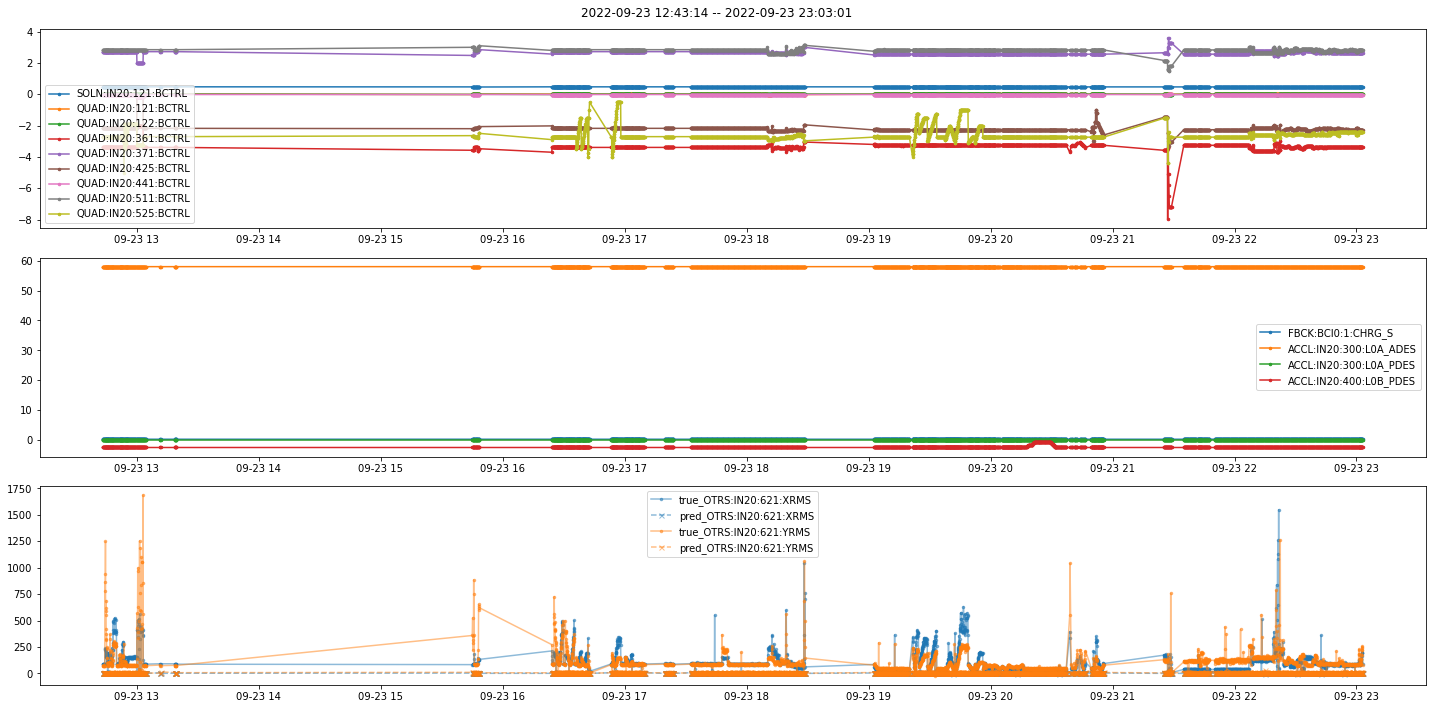

In [108]:
fig, ax = plot_series(data, columns=list(input_dict.keys())+['OTRS:IN20:621:XRMS', 'OTRS:IN20:621:YRMS'], pred_df=model_df)
plt.show()

In [109]:
data[outputs[0:2]].describe()

,OTRS:IN20:621:XRMS,OTRS:IN20:621:YRMS
count,3421.000000,3421.000000
mean,110.654633,112.445810
std,102.582752,105.630262
min,-5.320092,-22.403753
25%,41.217356,70.186863
50%,87.503631,86.184654
75%,128.922693,122.298521
max,1548.547770,1687.887286


In [110]:
model_df[outputs[0:2]].describe()

,OTRS:IN20:621:XRMS,OTRS:IN20:621:YRMS
count,3421.000000,3421.000000
mean,2.757657,5.402309
std,2.236701,3.359903
min,-7.016410,0.079089
25%,0.542138,2.946349
50%,2.351748,5.671740
75%,5.047122,7.354510
max,6.712275,33.329594


In [114]:
chunked_dfs = chunk_dataset(data)
chunked_model_dfs = chunk_dataset(model_df)

0 258
258 291
291 1295
1295 2524
Found 5 dataframes
0 1536
1536 2766
Found 3 dataframes


ValueError: x and y must have same first dimension, but have shapes (258,) and (1536,)

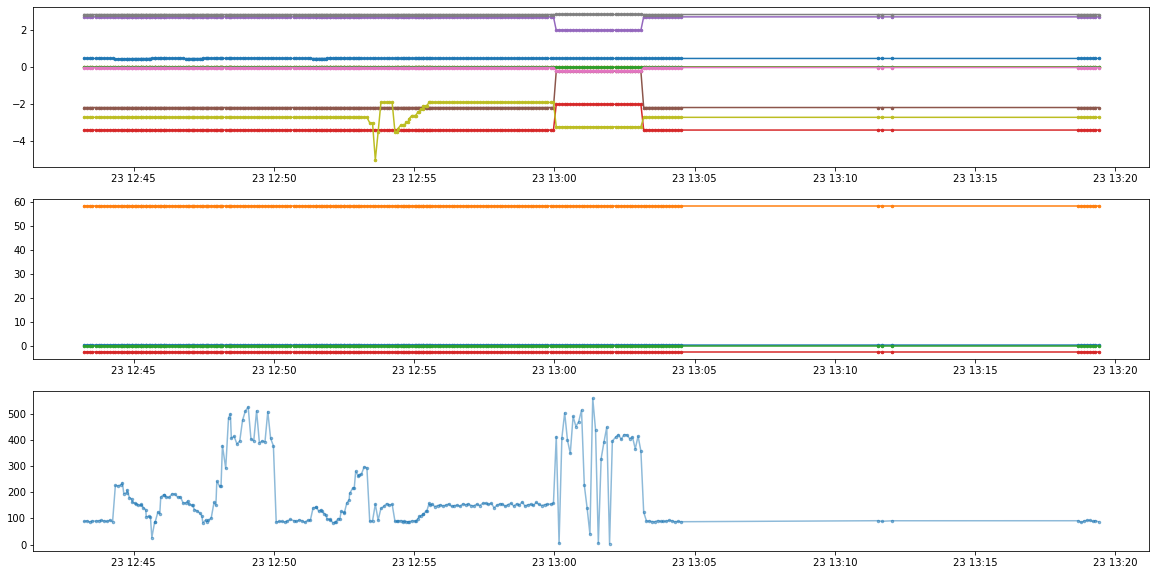

In [112]:
for true_df, pred_df in zip(chunked_dfs, chunked_model_dfs):
    fig, ax = plot_series(true_df, columns=list(input_dict.keys())+['OTRS:IN20:621:XRMS', 'OTRS:IN20:621:YRMS'], pred_df=pred_df)
    plt.show()